In [1]:
import cv2
import mediapipe as mp

#进度条库
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

#使用ipython魔法方法，将绘制得到的图像直接嵌入在notebook单元格中
%matplotlib inline

In [2]:
#定义可视化图像函数
def look_img(img):
    '''opencv读入图像格式为BGR。matplotlib可视化格式为RGB，因此需将BGR转化为RGB'''
    img_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()

In [3]:
#导入solution
mp_hands = mp.solutions.hands

#导入模型
hands = mp_hands.Hands(static_image_mode=False,       #是静态图片还是连续视频帧
                      max_num_hands=4,                #最多检测几只手
                      min_detection_confidence=0.5,   #置信度阈值
                      min_tracking_confidence=0.5,    #追踪阈值
                      )

#导入绘图函数
mpDraw = mp.solutions.drawing_utils

In [4]:
#从图片文件夹读入图像，opencv读入格式为BGR格式

img = cv2.imread('./images/Camera1.jpg')

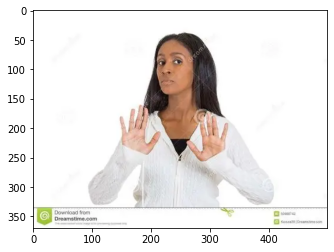

In [5]:
look_img(img)

In [6]:
# 水平镜像翻转图像，使得图中的左右手与真实左右手相对应
#参数，1：水平翻转，0：竖直翻转，-1：水平和竖直都翻转
img = cv2.flip(img,1)

# BGR转RGB
img_RGB = cv2.cvtColor(img,cv2.COLOR_BGRA2RGB)

#将RGB图像输入模型。获取预测结果
results = hands.process(img_RGB)

### 索引为0的手

In [7]:
results.multi_handedness[0].classification[0].score

0.9950695633888245

In [8]:
results.multi_handedness[0].classification[0].label

'Right'

### 索引为1的手

In [9]:
results.multi_handedness[1].classification[0].label

'Left'

In [10]:
results

mediapipe.python.solution_base.SolutionOutputs

In [11]:
results.multi_handedness

[classification {
   index: 1
   score: 0.9950695633888245
   label: "Right"
 },
 classification {
   index: 0
   score: 1.0
   label: "Left"
 }]

## 索引为0的手的手腕根部（0号关键点）

In [12]:
hand_21 = results.multi_hand_landmarks[0]

# 获取图像宽高
h,w = img.shape[0],img.shape[1]


cx = int(hand_21.landmark[0].x * w)
cy = int(hand_21.landmark[0].y * h)
cz = hand_21.landmark[0].z

In [13]:
print(cx,cy,cz)

329 239 -1.820570651034359e-05


### 索引为0的手的食指指尖（8号关键点）

In [14]:
cx = int(hand_21.landmark[8].x * w)
cy = int(hand_21.landmark[8].y * h)
cz = hand_21.landmark[8].z

In [15]:
print(cx,cy,cz)

306 170 -0.1209946870803833


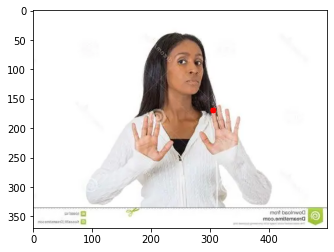

In [16]:
### 绘制圆：图像、圆心坐标、半径、BGR颜色、最后一个参数为线宽，-1表示填充

img = cv2.circle(img,(cx,cy),5,(0,0,255),-1)
look_img(img)

## 左右手信息

In [17]:
handness_str = ''

if results.multi_hand_landmarks:   #如果检测到手
    for hand_idx in range(len(results.multi_hand_landmarks)):
        hand_21 = results.multi_hand_landmarks[hand_idx]    #获取手的所有关键点坐标
        temp_handness = results.multi_handedness[hand_idx].classification[0].label
        handness_str += str(hand_idx) + ':' + temp_handness + ' '

In [18]:
handness_str

'0:Right 1:Left '

## 可视化不同种类关键点及深度

In [19]:
if results.multi_hand_landmarks:   #如果检测到手
    
    handness_str = ''
    index_finger_tip_str = ''
    for hand_idx in range(len(results.multi_hand_landmarks)):
        
        #获取该手的21个关键点坐标
        hand_21 = results.multi_hand_landmarks[hand_idx] 
        
        #可视化关键点及骨架连线
        mpDraw.draw_landmarks(img,hand_21,connections = mp_hands.HAND_CONNECTIONS)
        
        #记录左右手信息
        temp_handness = results.multi_handedness[hand_idx].classification[0].label
#        handness_str += str(hand_idx) + ':' + temp_handness + ' '       
        handness_str += '{}:{} '.format(hand_idx,temp_handness)
        
        #获取手腕根部深度坐标
        cz0 = hand_21.landmark[0].z
        
        for i in range(21):   #遍历该手的21个关键点
            
            #获取3D坐标
            cx = int(hand_21.landmark[i].x * w)
            cy = int(hand_21.landmark[i].y * h)
            cz = hand_21.landmark[i].z
            depth_z = cz0 - cz
            
            #用圆的半径反映深度大小
            radius = int(6 * (1 + depth_z))
            
            if i == 0:    #手腕
                img = cv2.circle(img,(cx,cy),radius * 2,(0,0,255),-1)
            if i == 8:   #食指指尖
                img = cv2.circle(img,(cx,cy),radius * 2,(193,184,67),-1)
                index_finger_tip_str += '{}:{} '.format(hand_idx,depth_z)
            if i in [1,5,9,13,17]:  #指根
                img = cv2.circle(img,(cx,cy),radius,(19,14,67),-1)
            if i in [2,6,10,14,18]:  #第一指节
                img = cv2.circle(img,(cx,cy),radius,(122,164,67),-1)                
            if i in [3,7,11,15,19]:  #第二指节
                img = cv2.circle(img,(cx,cy),radius,(12,150,89),-1)                
            if i in [4,12,16,20]:  #指尖（除食指指尖）
                img = cv2.circle(img,(cx,cy),radius,(223,155,60),-1)            
    
    scaler = 1
    img = cv2.putText(img,handness_str,(25 * scaler,100 * scaler),cv2.FONT_HERSHEY_SIMPLEX,1.25 * scaler,(255,0,0),2 * scaler)
    img = cv2.putText(img,index_finger_tip_str,(25 * scaler,150 * scaler),cv2.FONT_HERSHEY_SIMPLEX,1.25 * scaler,(255,0,255),2 * scaler)

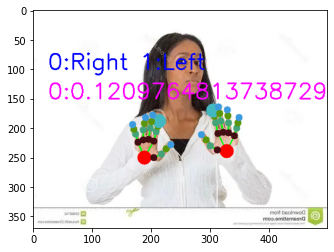

In [20]:
img_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img_RGB)

In [21]:
cv2.imwrite('B.jpg',img)

True